# Découverte des Datasets

Analyse du jeu de données

In [1]:
DATASET_1 = {
    "name": "imagenet-val-images",
    "path": "/Users/me/Documents/Work/Dev/_data/imagene_val_images",
    "size": 50000
}

DATASET_2 = {
    "name": "imagenet-sample-images",
    "path": "/Users/me/Documents/Work/Dev/_data/imagenet-sample-images-master",
    "size": 1000
}

In [2]:
def get_title(filename, datapath):
    if datapath == DATASET_1["path"]:
        return filename.replace("ILSVRC2012_val_", "").replace(".JPEG", "")
    elif datapath == DATASET_2["path"]:
        return filename.replace(".JPEG", "")

Analyses de deux jeux de données qui sont des extraits de Imagenet, jeu de données
principalement utilisé dans l'article.
- "{{dataset1["path"]}}" (dans _{{dataset1["path"]}}_) contenant {{dataset1["size"]}} images.
- "{{dataset2["path"]}}" (dans _{{dataset2["path"]}}_) contenant {{dataset2["size"]}} images.

In [3]:
import os
import matplotlib.pyplot as plt
from typing import Tuple

import torch
from torch.utils.data import Dataset
from torchvision import transforms as T
import torchvision.transforms.functional as F
from torch.utils.data import DataLoader
from torchvision.io import read_image

from tqdm import tqdm

from PIL import Image

> Attention : utilisation d'un répertoire de données en dehors de l'environnement do notebook !

In [4]:
DataPath = DATASET_2["path"]
ImageFile = "n04008634_projectile.JPEG" # if DATASET_2
# ImageFile = "ILSVRC2012_val_00038102_n01756291.JPEG" # if DATASET_1

Using `PyTorch` lib

Dimensions torch.Size([1, 500, 334]) 
Valeur min: 0 
Valeur max: 255


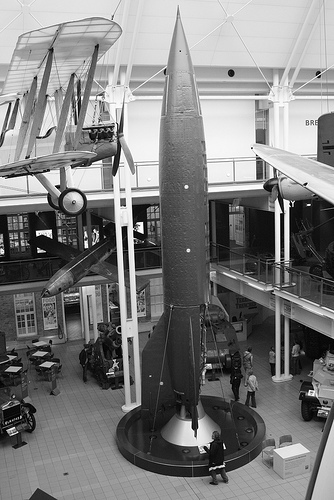

In [5]:
filename = os.path.join(DataPath, ImageFile)
img1_t = read_image(filename)
print("Dimensions", img1_t.size(), "\nValeur min:", img1_t.min().item(), "\nValeur max:", img1_t.max().item())
img1 = T.functional.to_pil_image(img1_t)
img1

Using `PIL` lib

Dimensions torch.Size([1, 500, 334]) 
Valeur min: 0.0 
Valeur max: 1.0


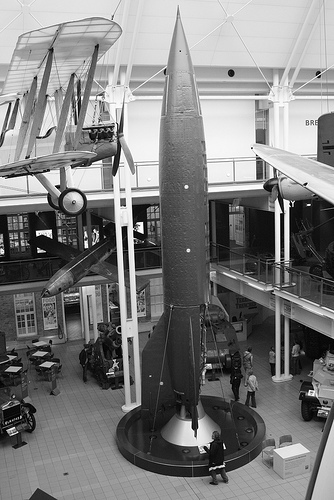

In [6]:
filename = os.path.join(DataPath, ImageFile)
input_image = Image.open(filename)
img2_t = T.functional.to_tensor(input_image)
print("Dimensions", img2_t.size(), "\nValeur min:", img2_t.min().item(), "\nValeur max:", img2_t.max().item())
input_image

Définition d'un classe spécifique de `Dataset`

In [7]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir: str, transform: T.Compose=None, extension: str=".jpg"):
        #self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.extension = extension.lower()
        self.files = [f for f in os.listdir(img_dir) if f.lower().endswith(self.extension)]


    def __len__(self):
        return len(self.files)


    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, str]:
        img_path = os.path.join(self.img_dir, self.files[idx])
        image = read_image(img_path)
        #print(self.files[idx], image.size(), end="")

        # If the image is not a RGB bit a 1 channel grey
        if image.size(0) == 1:
            #print(self.files[idx])
            image = image.repeat(3, 1, 1)
            #print(image.size())
        
        if self.transform:
            image = self.transform(image)
        
        return image, self.files[idx]
    
    @classmethod
    def use_read_image(cls):
        return True

Transformations des images similaires à l'article :
- plus petite des deux dimensions (H, W) est 256
- réduction centrale de l'image avec dimension (254, 254)
- niveau de couleur compris dans [0, 1] si besoin
- la normalisation sera incluse plus tard

In [8]:
transforms_list_1 = [
    T.Resize(256),
    T.CenterCrop(224),
]

if CustomImageDataset.use_read_image():
    transforms_list_1.append(
        T.Lambda(lambda t: t/255.),
    )

transforms1 = T.Compose(transforms_list_1)

imagenets = CustomImageDataset(DataPath, transform=transforms1, extension=".JPEG")

In [9]:
len(imagenets)

1000

In [10]:
imageloader = DataLoader(imagenets, batch_size=128)

Feature batch shape: torch.Size([128, 3, 224, 224])
0.04313725605607033 0.9921568632125854


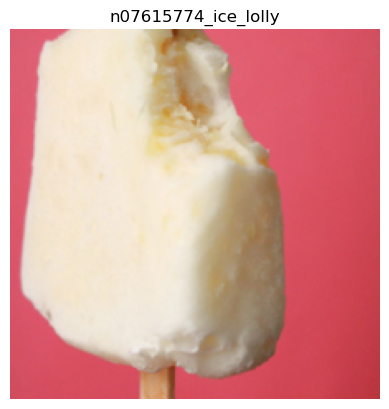

In [28]:
# Display image and label.
features, files = next(iter(imageloader))
print(f"Feature batch shape: {features.size()}")
img = features[0].squeeze()
file = files[0]
print(img.min().item(), img.max().item())
plt.imshow(F.to_pil_image(img))
plt.title(get_title(file, DataPath))
plt.axis("off")
plt.show()

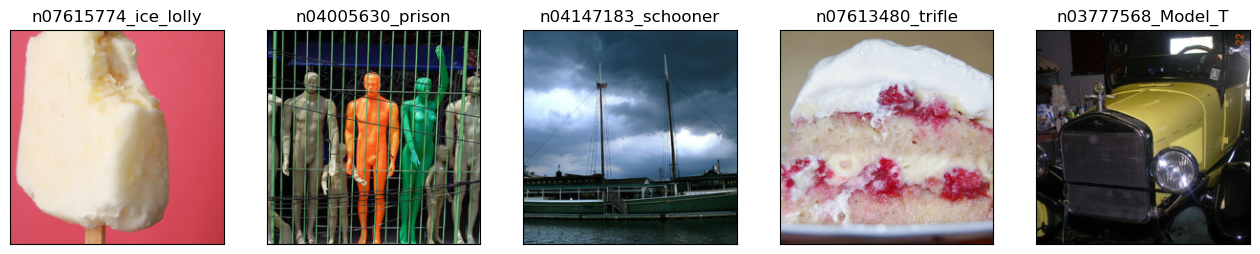

In [12]:
for batch_idx, inputs in enumerate(imageloader):
    fig = plt.figure(figsize = (16, 8))
    for i in range(5):
        ax = fig.add_subplot(2, 5, i + 1, xticks = [], yticks = [])
        plt.title(get_title(inputs[1][i], DataPath))
        plt.imshow(inputs[0][i].numpy().transpose(1, 2, 0))
    break

In [13]:
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for inputs in tqdm(imageloader):
    pictures = inputs[0]
    psum    += pictures.sum(axis        = [0, 2, 3])
    psum_sq += (pictures ** 2).sum(axis = [0, 2, 3])

100%|██████████| 8/8 [00:04<00:00,  1.61it/s]


In [14]:
image_size = 224
count = len(imageloader.dataset) * image_size * image_size

# mean and STD
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('Training data stats:')
print('- mean:', total_mean.numpy())
print('- std: ', total_std.numpy())

Training data stats:
- mean: [0.49069777 0.4582515  0.40877318]
- std:  [0.26863366 0.26152524 0.2731904 ]


In [15]:
processed_mean = total_mean.numpy()
processed_std = total_std.numpy()

# Source : https://pytorch.org/vision/main/models/generated/torchvision.models.alexnet.html
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# Initializing the normalization values
norm_mean = imagenet_mean
norm_std = imagenet_std

In [16]:
transforms_list_2 = [
    T.Resize(256),
    T.CenterCrop(224),
]

if CustomImageDataset.use_read_image():
    transforms_list_2.append(
        T.Lambda(lambda t: t/255.),
    )

transforms_list_2.append(T.Normalize(mean=norm_mean, std=norm_std))

transforms2 = T.Compose(transforms_list_2)

imagenets2 = CustomImageDataset(DataPath, transform=transforms2, extension=".JPEG")
imageloader2 = DataLoader(imagenets2, batch_size=128)

In [19]:
import numpy as np

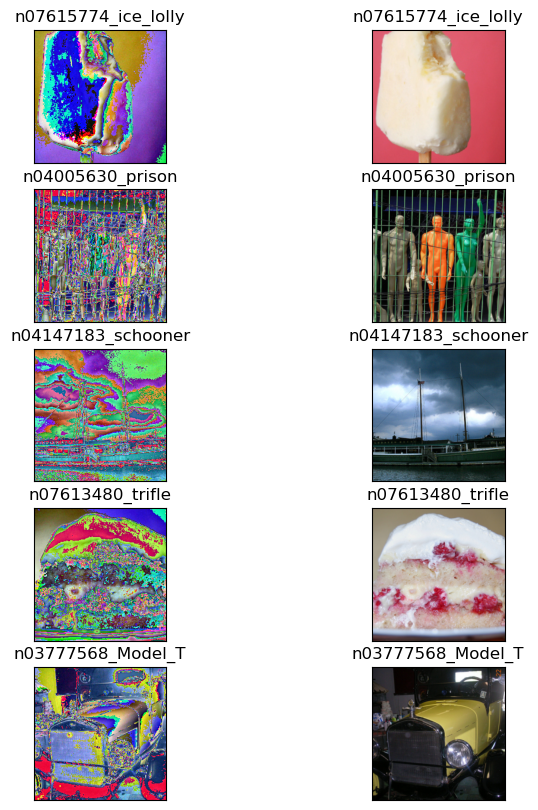

In [39]:
for batch_idx, inputs in enumerate(imageloader2):
    fig = plt.figure(figsize = (8, 10))
    for i in range(5):
        ax = fig.add_subplot(5, 2, 2*i + 1, xticks = [], yticks = [])
        ax.set_title(get_title(inputs[1][i], DataPath))
        ax.imshow((inputs[0][i].numpy().transpose(1, 2, 0) * 255).astype(np.uint8))

        ax = fig.add_subplot(5, 2, 2*i + 2, xticks = [], yticks = [])
        ax.set_title(get_title(inputs[1][i], DataPath))
        ax.imshow(((inputs[0][i].numpy().transpose(1, 2, 0) * norm_std + norm_mean) * 255).astype(np.uint8))
    break
plt.show()